In [17]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%autoreload 2

In [19]:
import matplotlib.pyplot as plt
import uproot_methods

In [20]:
import libwwz

In [21]:
import uproot
import os
import numpy as np
import pandas as pd

In [22]:
from geeksw.utils.core import concatenate
from geeksw.utils.data_loader_tools import make_data_loader, TreeWrapper, list_root_files_recursively

In [23]:
import pyarrow.parquet as pq
import pandas as pd

In [24]:
_dataset = pq.ParquetDataset("/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/skims/2017_WWZ_four_lepton_skim/parquet")
df_full = _dataset.read_pandas().to_pandas()
#nano_event = _df["evt"].values

In [25]:
df_full

,evt,evt_passgoodrunlist,evt_scale1fb,firstgoodvertex,hasTau,isData,lumi,met_gen_phi,met_gen_pt,nTrueInt,...,VetoLepton_ip3d_3,VetoLepton_sip3d_3,VetoLepton_pfRelIso03_all_wLep_3,VetoLepton_mediumId_3,VetoLeptonPair_mass_01,VetoLeptonPair_mass_02,VetoLeptonPair_mass_03,VetoLeptonPair_mass_12,VetoLeptonPair_mass_13,VetoLeptonPair_mass_23
0,503,True,1.0,0,True,False,2,0.957520,37.437500,25.0,...,0.000822,0.472656,0.000000,True,143.697401,62.438066,90.464584,93.477148,37.733923,67.137042
1,502,True,1.0,0,True,False,2,-0.895020,31.546875,31.0,...,0.005295,1.458008,0.000000,True,151.404266,40.771396,93.403486,23.751724,55.727576,29.217539
2,505,True,1.0,0,True,False,2,-1.295898,64.687500,42.0,...,0.006180,1.581055,0.101182,True,324.954213,212.194452,88.756172,81.510747,61.287820,39.509616
3,506,True,1.0,0,True,False,2,-0.474365,87.000000,29.0,...,0.000734,0.540527,0.000000,True,485.168165,485.085465,90.716882,55.521427,88.122441,80.697789
4,509,True,1.0,0,True,False,2,1.686523,77.562500,26.0,...,0.004650,1.261719,0.000000,True,294.926013,229.174682,250.270564,89.220929,80.797395,80.862403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776026,1561484,True,1.0,0,True,False,3123,-0.308105,90.187500,28.0,...,0.002522,1.143555,0.027120,True,257.916769,197.636105,185.584127,91.244896,236.715948,166.844858
776027,1561490,True,1.0,0,True,False,3123,-2.962891,198.125000,31.0,...,0.006710,1.272461,0.000000,True,327.107632,289.383912,30.162529,118.092972,90.331441,89.411150
776028,1561485,True,1.0,0,True,False,3123,-0.555176,6.265625,42.0,...,0.000274,0.229614,0.000000,True,203.640905,126.851868,95.132182,100.397624,69.520810,89.670707
776029,1561481,True,1.0,0,True,False,3123,-0.408203,85.250000,59.0,...,0.001357,0.981445,0.000000,True,81.748331,84.613287,65.386663,34.576776,52.841185,27.135409


In [26]:
def passes_Z_id(df):
    df_out = pd.DataFrame()
    for i in range(4):
        base_selection = df[f"VetoLepton_ip3d_{i}"].abs() / df[f"VetoLepton_sip3d_{i}"] < 4
        
        is_ele = df[f"VetoLepton_pdgId_{i}"].abs() == 11
        is_mu = df[f"VetoLepton_pdgId_{i}"].abs() == 13
        
        electron_selection = df[f"VetoLepton_pfRelIso03_all_wLep_{i}"] < 0.2
        
        muon_selection = df[f"VetoLepton_mediumId_{i}"] & df[f"VetoLepton_pfRelIso03_all_wLep_{i}"] < 0.25
        
        selection = base_selection & ((is_ele & electron_selection) | (is_mu & muon_selection))
        
        df_out[f"VetoLepton_passesZid_{i}"] = selection
    return df_out

In [27]:
def passes_W_id(df):
    df_out = pd.DataFrame()
    for i in range(4):
        base_selection = df[f"VetoLepton_ip3d_{i}"].abs() / df[f"VetoLepton_sip3d_{i}"] < 4
        
        is_ele = df[f"VetoLepton_pdgId_{i}"].abs() == 11
        is_mu = df[f"VetoLepton_pdgId_{i}"].abs() == 13
        
        electron_selection = df[f"VetoLepton_mediumId_{i}"] & df[f"VetoLepton_pfRelIso03_all_wLep_{i}"] < 0.2
        
        muon_selection = df[f"VetoLepton_mediumId_{i}"] & df[f"VetoLepton_pfRelIso03_all_wLep_{i}"] < 0.15
        
        selection = base_selection & ((is_ele & electron_selection) | (is_mu & muon_selection))
        
        df_out[f"VetoLepton_passesWid_{i}"] = selection
    return df_out

In [28]:
def jagged_pair_masses(df):
    import awkward
    content = df[["VetoLeptonPair_mass_01", "VetoLeptonPair_mass_02", "VetoLeptonPair_mass_03", 
               "VetoLeptonPair_mass_12", "VetoLeptonPair_mass_13", "VetoLeptonPair_mass_23"]].values.flatten()
    
    return awkward.JaggedArray.fromcounts(6 + np.zeros(len(df), dtype=np.int), content)

In [29]:
def jagged_lepton_variable(df, variable):
    import awkward
    content = df[[f"VetoLepton_{variable}_0",
                 f"VetoLepton_{variable}_1",
                 f"VetoLepton_{variable}_2",
                 f"VetoLepton_{variable}_3"]].values.flatten()
    
    return awkward.JaggedArray.fromcounts(4 + np.zeros(len(df), dtype=np.int), content)

In [30]:
jagged_lepton_variable(df_full, "pt")

<JaggedArray [[139.17367553710938 99.70079803466797 78.56649780273438 22.383941650390625] [342.103271484375 128.05360412597656 36.159324645996094 10.100736618041992] [189.14801025390625 70.32777404785156 31.609167098999023 10.948343276977539] ... [99.73120880126953 78.73763275146484 52.699317932128906 37.645652770996094] [77.63190460205078 31.449344635009766 23.090087890625 14.866924285888672] [56.65717697143555 42.4954719543457 39.98412322998047 38.79512405395508]] at 0x7f4e9484bc88>

In [31]:
def to_singleton_jagged_array(arr):
    import awkward
    return awkward.JaggedArray.fromcounts(np.ones(len(arr), dtype=np.int), arr)

In [32]:
def find_boson_candidate_indices(df):
    z_mass = 91.19

    def find_z_candidates(df):

        df_out = pd.DataFrame()

        for i in range(4):
            for j in range(4):
                if j <= i:
                    continue
                mass = df[f"VetoLeptonPair_mass_{i}{j}"].copy().values
                mass[df[f"VetoLepton_pdgId_{i}"] + df[f"VetoLepton_pdgId_{j}"] != 0] = np.nan
                mass[~df[f"VetoLepton_passesZid_{i}"]] = np.nan
                mass[~df[f"VetoLepton_passesZid_{j}"]] = np.nan

                pt_i = df[f"VetoLepton_pt_{i}"]
                pt_j = df[f"VetoLepton_pt_{j}"]
                mass[np.max([pt_i, pt_j], axis=0) < 25] = np.nan
                mass[np.min([pt_i, pt_j], axis=0) < 10] = np.nan

                df_out[f"VetoLeptonPair_z_cand_mass_{i}{j}"] = mass

        return df_out

    z_df = find_z_candidates(df)

    def z_idx_to_lep_idx(z_idx):
        lep_1_idx = 0 + (z_idx > 2)
        lep_2_idx = z_idx + 1

        lep_1_idx = lep_1_idx + (z_idx > 4)

        lep_2_idx[z_idx == 2] = 3
        lep_2_idx[z_idx == 3] = 2
        lep_2_idx[z_idx == 4] = 3
        lep_2_idx[z_idx == 5] = 3
        
        lep_1_idx[z_idx < 0] = -99
        lep_2_idx[z_idx < 0] = -99

        return lep_1_idx, lep_2_idx

    has_z_cand = ~(np.sum(~np.isnan(z_df.values), axis=1) == 0)

    in_z_window = has_z_cand[:]
    in_z_window[has_z_cand] = np.nanmin(np.abs(z_df[has_z_cand].values - z_mass), axis=1) < 10.0
    z_idx = np.nanargmin(np.abs(z_df[in_z_window].values - z_mass), axis=1)

    w_lep_1_idx = np.zeros(len(df), dtype=np.int) - 99
    w_lep_2_idx = np.zeros(len(df), dtype=np.int) - 99

    z_lep_1_idx = np.zeros(len(df), dtype=np.int) - 99
    z_lep_2_idx = np.zeros(len(df), dtype=np.int) - 99

    a, b = z_idx_to_lep_idx(z_idx)
    z_lep_1_idx[in_z_window] = a
    z_lep_2_idx[in_z_window] = b

    w_lep_1_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 1)] = 2
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 2)] = 1
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 3)] = 1
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 2)] = 0
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 3)] = 0
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 2, z_lep_2_idx == 3)] = 0

    w_lep_2_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 1)] = 3
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 2)] = 3
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 3)] = 2
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 2)] = 3
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 3)] = 2
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 2, z_lep_2_idx == 3)] = 1
    
    # Don't consider W-leptons if they don' pass the ID
    passes_w_id = jagged_lepton_variable(df, "passesWid")[in_z_window]
    jagged_w_lep_1_idx_in_z_window = to_singleton_jagged_array(w_lep_1_idx[in_z_window])
    jagged_w_lep_2_idx_in_z_window = to_singleton_jagged_array(w_lep_2_idx[in_z_window])
    passes = np.logical_and(passes_w_id[jagged_w_lep_1_idx_in_z_window],
                            passes_w_id[jagged_w_lep_2_idx_in_z_window]).flatten()
    passes_all = np.array(in_z_window)
    passes_all[in_z_window] = passes
    w_lep_1_idx[~passes_all] = -99
    w_lep_2_idx[~passes_all] = -99
    
    # Don't consider W-leptons if they are not opposite charge
    w_lep_charge = np.sign(jagged_lepton_variable(df, "pdgId"))[in_z_window]
    w_charge_1 = w_lep_charge[jagged_w_lep_1_idx_in_z_window].flatten()
    w_charge_2 = w_lep_charge[jagged_w_lep_2_idx_in_z_window].flatten()
    passes = w_charge_1 + w_charge_2 == 0
    passes_all = np.array(in_z_window)
    passes_all[in_z_window] = passes
    w_lep_1_idx[~passes_all] = -99
    w_lep_2_idx[~passes_all] = -99
    
    # W candidate pt cuts
    w_cand_pt = jagged_lepton_variable(df, "pt")[in_z_window]
    w_pt_1 = w_cand_pt[jagged_w_lep_1_idx_in_z_window].flatten()
    w_pt_2 = w_cand_pt[jagged_w_lep_2_idx_in_z_window].flatten()
    passes = np.logical_and(np.max([w_pt_1, w_pt_2], axis=0) > 25,
                            np.min([w_pt_1, w_pt_2], axis=0) > 10)

    passes_all = np.array(in_z_window)
    passes_all[in_z_window] = passes
    w_lep_1_idx[~passes_all] = -99
    w_lep_2_idx[~passes_all] = -99

    return pd.DataFrame(dict(z_lep_1_idx=z_lep_1_idx, z_lep_2_idx=z_lep_2_idx,
                             w_lep_1_idx=w_lep_1_idx, w_lep_2_idx=w_lep_2_idx))

In [35]:
def lep_idx_to_z_idx(z_lep_1_idx, z_lep_2_idx):
    z_idx = np.zeros(len(z_lep_1_idx), dtype=np.int) - 99
    
    z_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 1)] = 0
    z_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 2)] = 1
    z_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 3)] = 2
    z_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 2)] = 3
    z_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 3)] = 4
    z_idx[np.logical_and(z_lep_1_idx == 2, z_lep_2_idx == 3)] = 5
    
    return z_idx

In [36]:
def get_z_cand_masses(df):
    has_z_cand_1 = df["z_lep_1_idx"] >= 0
    has_z_cand_2 = df["w_lep_1_idx"] >= 0
    
    z_lep_1_idx = df["z_lep_1_idx"][has_z_cand_1].values
    z_lep_2_idx = df["z_lep_2_idx"][has_z_cand_1].values
    w_lep_1_idx = df["w_lep_1_idx"][has_z_cand_2].values
    w_lep_2_idx = df["w_lep_2_idx"][has_z_cand_2].values
    
    pair_masses = jagged_pair_masses(df)
    
    z_cand_1_mass = pair_masses[has_z_cand_1][to_singleton_jagged_array(lep_idx_to_z_idx(z_lep_1_idx, z_lep_2_idx))]
    z_cand_2_mass = pair_masses[has_z_cand_2][to_singleton_jagged_array(lep_idx_to_z_idx(w_lep_1_idx, w_lep_2_idx))]
    
    lep_pdg_id = jagged_lepton_variable(df, "pdgId")[has_z_cand_2]
    w_pdg_1 = lep_pdg_id[to_singleton_jagged_array(w_lep_1_idx)]
    w_pdg_2 = lep_pdg_id[to_singleton_jagged_array(w_lep_2_idx)]
    
    z_cand_2_mass[w_pdg_1 + w_pdg_2 != 0] = np.nan

    df_out = pd.DataFrame(index=df.index)
    df_out.loc[has_z_cand_1, "ZCand_mass_0"] = z_cand_1_mass
    df_out.loc[has_z_cand_2, "ZCand_mass_1"] = z_cand_2_mass
    return df_out

474.14383

In [38]:
def is_emu_category(df):
    selection = np.sum(df[["z_lep_1_idx", "z_lep_2_idx", "w_lep_1_idx", "w_lep_2_idx"]].values, axis=1) == 6
    selection = np.logical_and(selection, df["ZCand_mass_1"].isna())
    return np.logical_and(selection, df["nb"] == 0)

In [39]:
def is_btag_emu_category(df):
    selection = np.sum(df[["z_lep_1_idx", "z_lep_2_idx", "w_lep_1_idx", "w_lep_2_idx"]].values, axis=1) == 6
    selection = np.logical_and(selection, df["ZCand_mass_1"].isna())
    return np.logical_and(selection, df["nb"] > 0)

In [40]:
def is_offz_category(df):
    selection = np.sum(df[["z_lep_1_idx", "z_lep_2_idx", "w_lep_1_idx", "w_lep_2_idx"]].values, axis=1) == 6
    selection = np.logical_and(selection, (df["ZCand_mass_1"] - 91.19).abs() > 10.)
    return selection

In [41]:
def is_onz_category(df):
    selection = np.sum(df[["z_lep_1_idx", "z_lep_2_idx", "w_lep_1_idx", "w_lep_2_idx"]].values, axis=1) == 6
    selection = np.logical_and(selection, (df["ZCand_mass_1"] - 91.19).abs() <= 10.)
    return selection

In [ ]:
def four_lepton_analysis(df):
    df = df_full[:].copy()
    df = pd.concat([df, passes_Z_id(df), passes_W_id(df)], axis=1)
    df_cands_idx = find_boson_candidate_indices(df)
    df = pd.concat([df, df_cands_idx], axis=1)
    df_z_cand_masses = get_z_cand_masses(df)
    df = pd.concat([df, df_z_cand_masses], axis=1)
    df.loc[is_btag_emu_category(df), "category"] = "BTagEMu"
    df["category"] = "uncategorized"
    df.loc[is_emu_category(df), "category"] = "EMu"
    df.loc[is_offz_category(df), "category"] = "OffZ"
    df.loc[is_onz_category(df), "category"] = "OnZ"
    return df

In [55]:

pre_skim_sumw = 1181.90185546875
df["genWeight"].sum()

474.14383

In [56]:
len(df)

776031

In [57]:
df.groupby("category")["genWeight"].sum() / 1181.90185546875 * 157 * 4.12

category
EMu               12.997242
OffZ              13.585909
OnZ                1.748573
uncategorized    231.161224
Name: genWeight, dtype: float32

In [42]:
df["genWeight"][is_btag_emu_category(df)].sum() / 1181.90185546875 * 157 * 4.12

2.141395145347839

In [43]:
df["genWeight"][is_emu_category(df)].sum() / 1181.90185546875 * 157 * 4.12

12.99724182947933

In [44]:
df["genWeight"][is_offz_category(df)].sum() / 1181.90185546875 * 157 * 4.12

13.585908157894329

In [45]:
df["genWeight"][is_onz_category(df)].sum() / 1181.90185546875 * 157 * 4.12

1.7485723938128606

In [46]:
df_z_cand_masses

,ZCand_mass_0,ZCand_mass_1
0,90.464584,93.477148
1,NaN,NaN
2,88.756172,NaN
3,90.716882,NaN
4,NaN,NaN
...,...,...
776026,NaN,NaN
776027,89.411150,NaN
776028,NaN,NaN
776029,NaN,NaN


In [47]:
import matplotlib.pyplot as plt

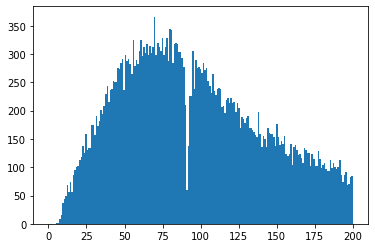

In [48]:
bins = np.linspace(0, 200, 200)
plt.hist(df_z_cand_masses["ZCand_mass_1"].dropna().values, bins=bins)
plt.show()